In [461]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from dmba import regressionSummary, exhaustive_search
from sklearn.metrics import r2_score, classification_report
from statsmodels.api import OLS
import statsmodels.api as sm
from scipy import stats
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import backward_elimination, forward_selection, stepwise_selection
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV



%matplotlib inline

In [372]:
features = pd.read_csv('data/features.csv')
stores = pd.read_csv('data/stores.csv')
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')
sampleSubmission = pd.read_csv('data/sampleSubmission.csv')

#### Part 1 understanding the original data

In [373]:
stores.head(3)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392


In [374]:
stores.dtypes

Store     int64
Type     object
Size      int64
dtype: object

In [375]:
features.head(3)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False


In [376]:
features.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [377]:
train.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


In [378]:
train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [379]:
train = train[train['Weekly_Sales'] >= 0]

#### Part 2 Data Preprocessing , Data Visualization and Feature Selection

In [380]:
#generate time data
features['Date'] = pd.to_datetime(features.Date, format = '%Y/%m/%d')
train['Date'] = pd.to_datetime(train.Date, format = '%Y/%m/%d')
test['Date'] = pd.to_datetime(test.Date, format = '%Y/%m/%d')

features['year'] = features['Date'].dt.year
features['month'] = features['Date'].dt.month
features['week'] = features['Date'].dt.isocalendar().week

In [381]:
# replace NA values with mean values or 0
features['CPI'].fillna(features['CPI'].mean(), inplace=True)
features['Unemployment'].fillna(features['Unemployment'].mean(), inplace=True)
features[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',  'MarkDown5']] = features[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',  'MarkDown5']].fillna(value=0)

In [382]:
#df = features[['Date', 'IsHoliday','week']]
#df[df['IsHoliday'] == True].drop_duplicates().sort_values('week')
# features['weight'] = features['IsHoliday'].apply(lambda x: 5 if x == True else 1)

In [383]:
# merge sales data with store features 
train_df = pd.merge(stores,  train)
train_df = pd.merge(train_df ,features)

test_df = pd.merge(stores, test)
test_df = pd.merge(test_df ,features)

In [384]:
train_df.dtypes

Store                    int64
Type                    object
Size                     int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
year                     int64
month                    int64
week                    UInt32
dtype: object

In [385]:
test_df.dtypes

Store                    int64
Type                    object
Size                     int64
Dept                     int64
Date            datetime64[ns]
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
year                     int64
month                    int64
week                    UInt32
dtype: object

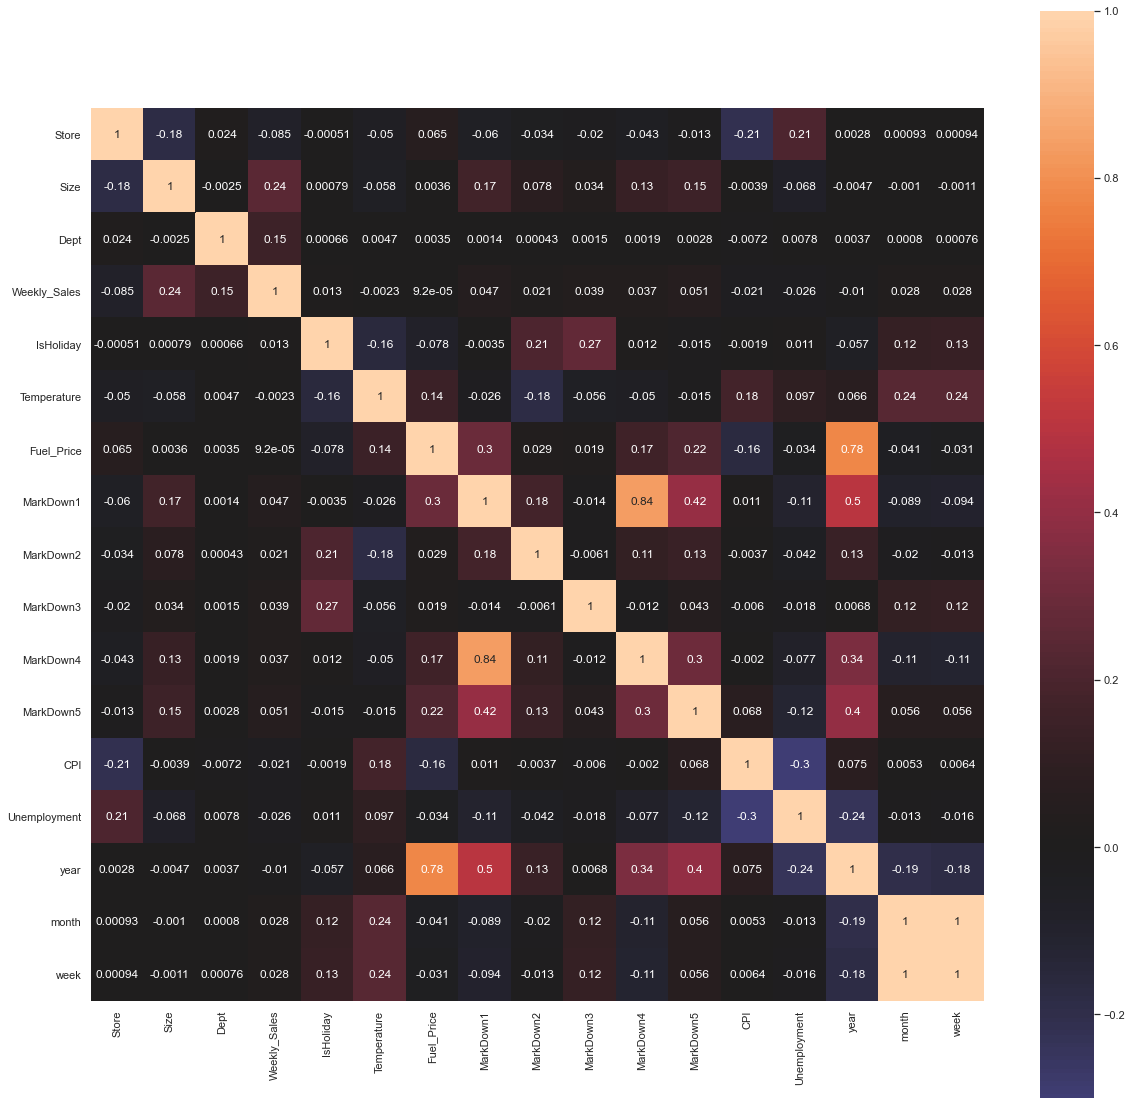

In [386]:
# create a heatmap of correlation matrix, using for feature selection
fig, ax = plt.subplots(figsize=(20, 20))
corr = train_df.corr()
sns.set_theme(style="white")
ax = sns.heatmap(corr, center=0,square=True, annot = True)
# from the heat map we notice that features like temperature, fuel_price, are not so relevent to the weekly sale.

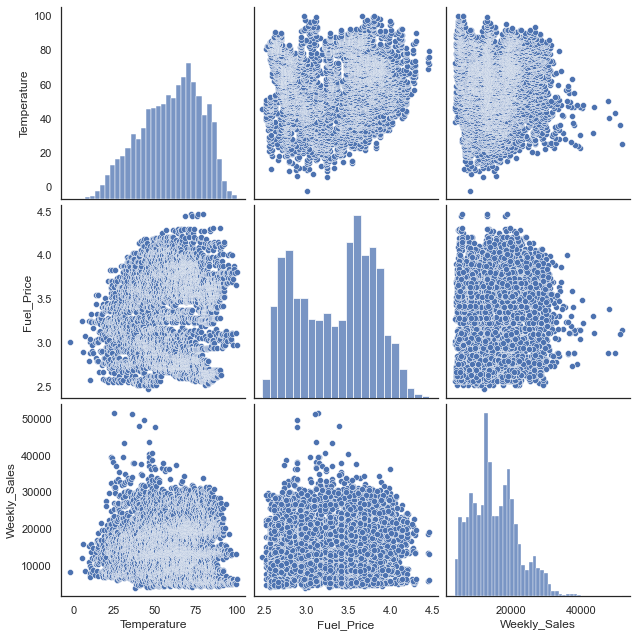

In [387]:
# analyize the realtionship between 'Temperature', 'Fuel_Price' with weekly sales:

df = train_df['Weekly_Sales'].groupby([train_df['Temperature'],train_df['Fuel_Price']]).mean().reset_index()
sns.pairplot(df, height=3)

#from the pari plot blow, we didn't figure out obvious ralationship between the weekly sales and these wariables, we should also drop them from the model.
train_df = train_df.drop(['Temperature', 'Fuel_Price'], axis = 1)
test_df = test_df.drop(['Temperature', 'Fuel_Price'], axis = 1)

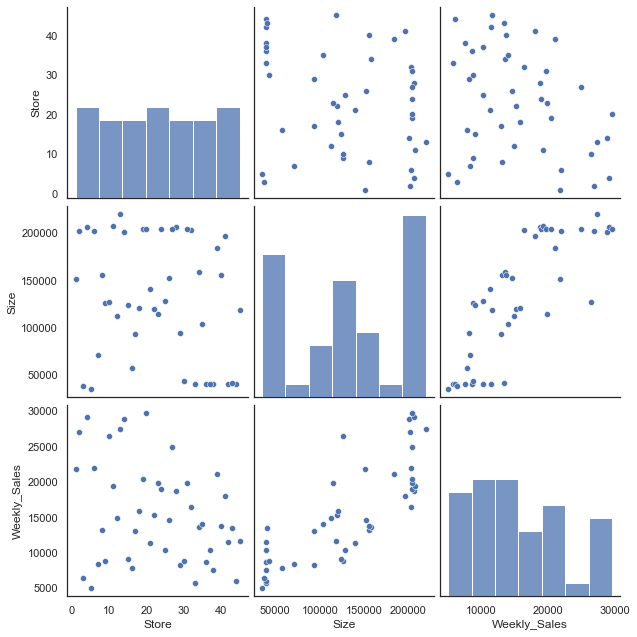

In [388]:
# figure out the correlation between store type, Size and weekly sales:
df = train_df['Weekly_Sales'].groupby([train_df['Store'], train_df['Size']]).mean().reset_index().sort_values('Weekly_Sales')
sns.pairplot(df, height=3)

<AxesSubplot:xlabel='Type', ylabel='Size'>

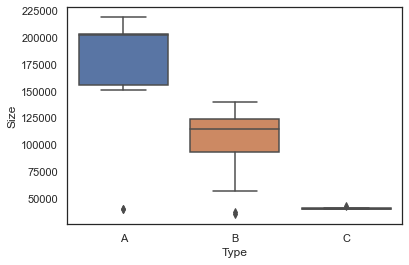

In [389]:
# it's obvious that type A has the highest level of size. There exists an correaltion between Type and Size.
# We should only select one and drop another in the model fitting
fig, ax = plt.subplots(1, 1)
sns.boxplot(x = stores['Type'], y =stores['Size'])

<AxesSubplot:xlabel='Date', ylabel='Weekly_Sales'>

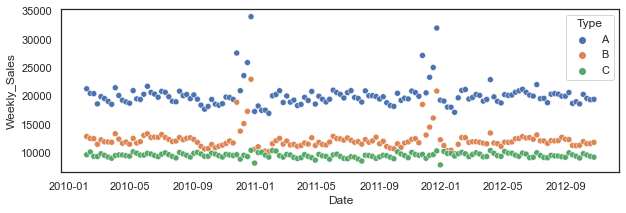

In [390]:
group = train_df['Weekly_Sales'].groupby([train_df['Type'], train_df['Date']]).mean().reset_index()
fig, ax = plt.subplots(figsize=(10, 3))
sns.scatterplot(data=group, x='Date', y="Weekly_Sales", hue="Type")

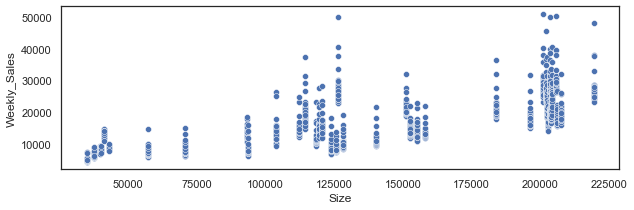

In [391]:
group = train_df['Weekly_Sales'].groupby([train_df['Size'], train_df['week']]).mean().reset_index()
fig, ax = plt.subplots(figsize=(10, 3))
sns.scatterplot(data=group, x='Size', y="Weekly_Sales")

#We decide to drop the 'Type' categorical variable to keep the numerical variable
train_df = train_df.drop(['Type'], axis = 1)
test_df = test_df.drop(['Type'], axis = 1)

No handles with labels found to put in legend.


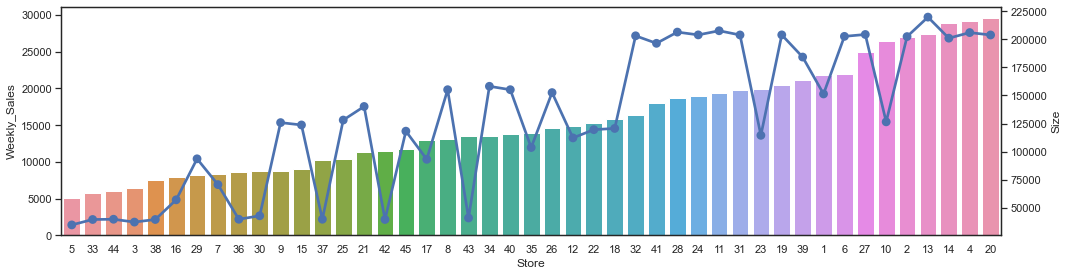

In [392]:
# barplot for weekly sales vs. store
group = train_df['Weekly_Sales'].groupby([train_df['Store'], train_df['Size']]).mean().reset_index().sort_values('Weekly_Sales')
fig, ax1 = plt.subplots(figsize=(15, 4))
sns.barplot(data=group, x='Store', y="Weekly_Sales",order=group['Store'], ax=ax1)
ax2 = ax1.twinx()
sns.pointplot(data=group, x='Store', y="Size",order=group['Store'] )
ax.set_xlabel('Store', fontsize=16)
ax.set_ylabel('Weekly Sales', fontsize=16)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# we notice that each store's weekly sales are different, one possible reason would be the store size:

In [393]:
# figure out the correlation between holiday weekly sales:
holiday_type = pd.DataFrame({'Super Bowl': ['12-Feb-10', '11-Feb-11', '10-Feb-12', '8-Feb-13'], 
'Labor Day': ['10-Sep-10', '9-Sep-11', '7-Sep-12', '6-Sep-13'],
'Thanksgiving': ['26-Nov-10','25-Nov-11', '23-Nov-12', '29-Nov-13'], 
'Christmas': ['31-Dec-10', '30-Dec-11','28-Dec-12', '27-Dec-13']})
holiday_type = holiday_type.unstack().reset_index()
holiday_type['Date'] = pd.to_datetime(holiday_type[0], format = '%d-%b-%y')

cols = [1,2]
holiday_type = holiday_type.drop(holiday_type.columns[cols], axis =1)
holiday_type = holiday_type.rename(columns={"level_0": "holiday_type"})
# holiday_type  = pd.get_dummies(holiday_type, columns = ['holiday_type'])
holiday_type['week_n'] = holiday_type['Date'].dt.isocalendar().week

holiday_type

,holiday_type,Date,week_n
0,Super Bowl,2010-02-12,6
1,Super Bowl,2011-02-11,6
2,Super Bowl,2012-02-10,6
3,Super Bowl,2013-02-08,6
4,Labor Day,2010-09-10,36
5,Labor Day,2011-09-09,36
6,Labor Day,2012-09-07,36
7,Labor Day,2013-09-06,36
8,Thanksgiving,2010-11-26,47
9,Thanksgiving,2011-11-25,47


In [394]:
df = train_df[['Date', 'IsHoliday','week']]
df[df['IsHoliday'] == True].drop_duplicates().sort_values('week')

,Date,IsHoliday,week
73,2010-02-12,True,6
3796,2011-02-11,True,6
7518,2012-02-10,True,6
2216,2010-09-10,True,36
5933,2011-09-09,True,36
9652,2012-09-07,True,36
3011,2010-11-26,True,47
6723,2011-11-25,True,47
3369,2010-12-31,True,52
7087,2011-12-30,True,52


In [395]:
df = test_df[['Date', 'IsHoliday','week']]
df[df['IsHoliday'] == True].drop_duplicates().sort_values('week')

,Date,IsHoliday,week
1006,2013-02-08,True,6
213,2012-11-23,True,47
576,2012-12-28,True,52


In [396]:
#attach the holiday tpye to the training data, and replace NA values with 0
train_df = pd.merge(train_df ,holiday_type, how = 'left')
train_df = train_df.drop(['week_n'], axis = 1)
test_df = pd.merge(test_df ,holiday_type,  how = 'left')
test_df = test_df.drop(['week_n'] , axis = 1)
train_df = pd.get_dummies(train_df, columns = ['holiday_type'] )
test_df = pd.get_dummies(test_df, columns = ['holiday_type'])
train_df[['holiday_type_Christmas', 'holiday_type_Labor Day', 'holiday_type_Super Bowl', 'holiday_type_Thanksgiving']] = train_df[['holiday_type_Christmas', 'holiday_type_Labor Day', 'holiday_type_Super Bowl', 'holiday_type_Thanksgiving']].fillna(value=0)
test_df[['holiday_type_Christmas', 'holiday_type_Super Bowl', 'holiday_type_Thanksgiving']] = test_df[['holiday_type_Christmas', 'holiday_type_Super Bowl', 'holiday_type_Thanksgiving']].fillna(value=0)

Text(0.5, 1.0, 'box plot after reset "IsHoliday"')

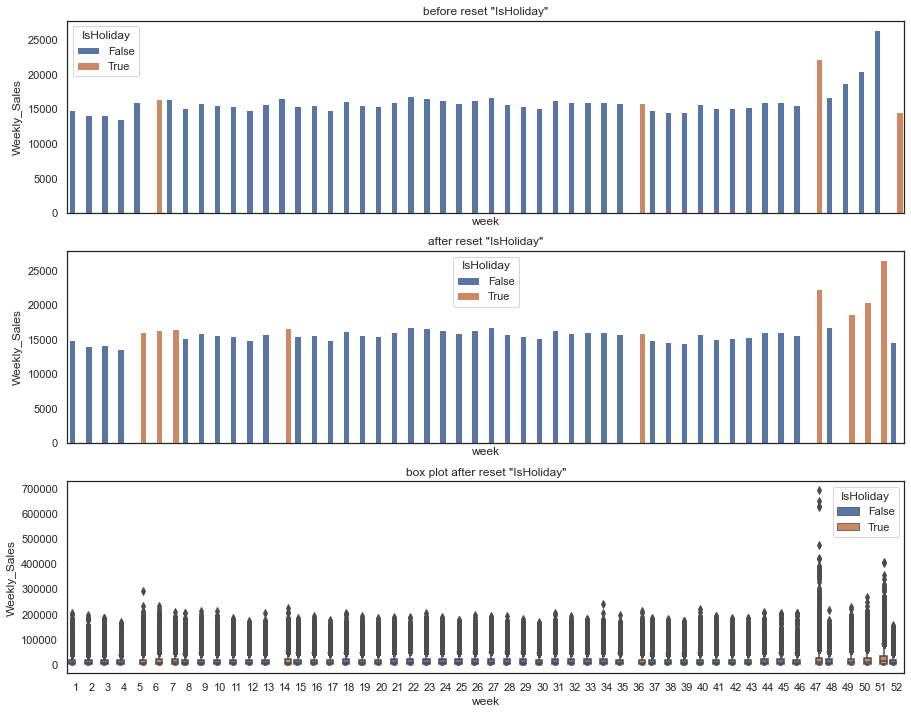

In [397]:
# display the relationship between week, holiday and weekly_sales.
fig, ax = plt.subplots(3, 1, figsize=(15, 12), sharex = True)

group = train_df['Weekly_Sales'].groupby([train_df['week'],train_df['IsHoliday']]).mean().reset_index()
sns.barplot(data=group, x='week', y="Weekly_Sales", hue = 'IsHoliday' , ax = ax[0])
ax[0].set_title('before reset "IsHoliday"')

#Here we notic that some weeks before holiday are also sensitive to the hodiday.
#We need to enhence this effect mannually. Meanwhile, we also add the Easter (week 14) and remove Labor Day(week 36)
w = pd.DataFrame([5, 6, 7, 14, 36, 47, 49, 50, 51])
train_df['IsHoliday'] = train_df['week'].apply(lambda x: x in w.values)
group = train_df['Weekly_Sales'].groupby([train_df['week'],train_df['IsHoliday']]).mean().reset_index()
sns.barplot(data=group, x='week', y="Weekly_Sales", hue = 'IsHoliday', ax = ax[1])
ax[1].set_title('after reset "IsHoliday"')

sns.boxplot(x='week', y='Weekly_Sales', data=train_df, hue='IsHoliday', ax = ax[2])
ax[2].set_title('box plot after reset "IsHoliday"')

In [398]:
#generate dummy variables for categorical data
train_df = pd.get_dummies(train_df, columns = ['IsHoliday'], drop_first=True)
test_df = pd.get_dummies(test_df, columns = ['IsHoliday'],drop_first=True)

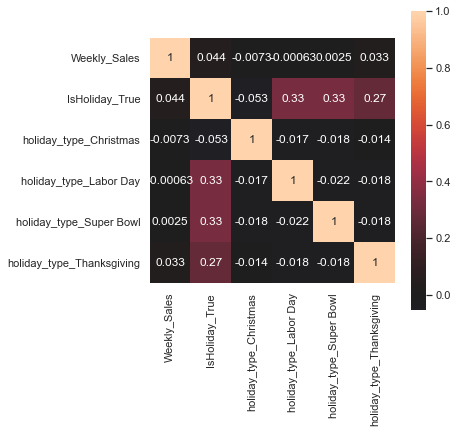

In [399]:
df = train_df[['Weekly_Sales', 'IsHoliday_True','holiday_type_Christmas', 'holiday_type_Labor Day', 'holiday_type_Super Bowl', 'holiday_type_Thanksgiving']]
fig, ax = plt.subplots(figsize=(5.5, 5.5))
corr = df.corr()
sns.set_theme(style="white")
ax = sns.heatmap(corr, center=0,square=True, annot = True)
#here we notice that the only holiday type correlated to weekly sales is thanks giving, so we drop our the resting 3
test_df = test_df.drop(['holiday_type_Christmas','holiday_type_Super Bowl'], axis = 1)
train_df = train_df.drop(['holiday_type_Christmas', 'holiday_type_Labor Day', 'holiday_type_Super Bowl'], axis = 1)

In [400]:
# analysis the distribution of weekly sales in different dapartments:
# fig, ax = plt.subplots(2, 1, figsize=(15, 8))
# sns.scatterplot(data=train_df, x='Dept', y="Weekly_Sales" , ax= ax[0])
# group = train_df['Weekly_Sales'].groupby([train_df['Dept']]).mean().reset_index()
# sns.barplot(data=group, x='Dept', y="Weekly_Sales", ax = ax[1])
# barplot for weekly sales vs. dapartment
# group = train_df['Weekly_Sales'].groupby([train_df['Dept'] ]).mean().reset_index().sort_values('Weekly_Sales')
# fig, ax = plt.subplots(figsize=(15, 4))
# sns.set_style("whitegrid")
# sns.barplot(data=group, x='Dept', y="Weekly_Sales", order = group['Dept'] )
# ax.set_xlabel('Dept', fontsize=16)
# ax.set_ylabel('Weekly Sales', fontsize=16)
# plt.tight_layout()
# plt.show()
#sns.histplot((group['Weekly_Sales']), bins = 15)

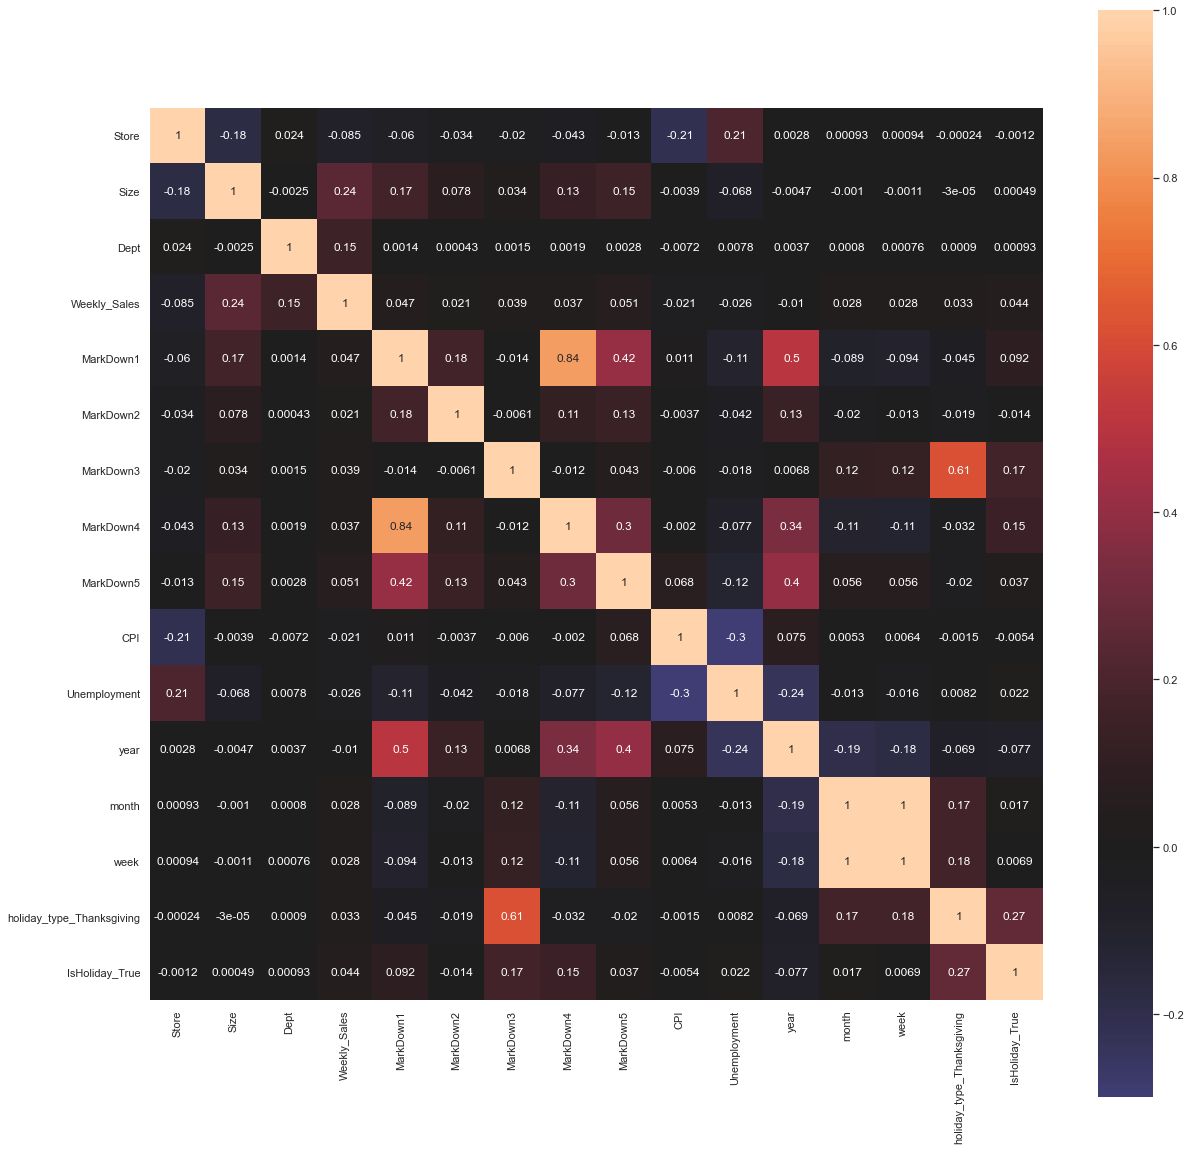

In [401]:
# create a heatmap of correlation matrix
fig, ax = plt.subplots(figsize=(20, 20))
corr = train_df.corr()
sns.set_theme(style="white")
ax = sns.heatmap(corr, center=0,square=True, annot = True)

In [402]:
# here we notice the 100% correlation between "month" and 'week'.
# Considering that our estimation is based on week, we drop the "month" variable.
# We notice the high correlation between 'MarkDown1' and 'MarkDown4', we drop 'MarkDown4'
# We notice the high correlation between 'MarkDown3' and 'holidy_type_Thanksgiving', we drop 'holidy_type_Thanksgiving'

test_df = test_df.drop(['month', 'MarkDown4', 'holiday_type_Thanksgiving', 'Unemployment'], axis = 1)
train_df = train_df.drop(['month', 'MarkDown4', 'holiday_type_Thanksgiving', 'Unemployment'], axis = 1)

<AxesSubplot:xlabel='week', ylabel='Weekly_Sales'>

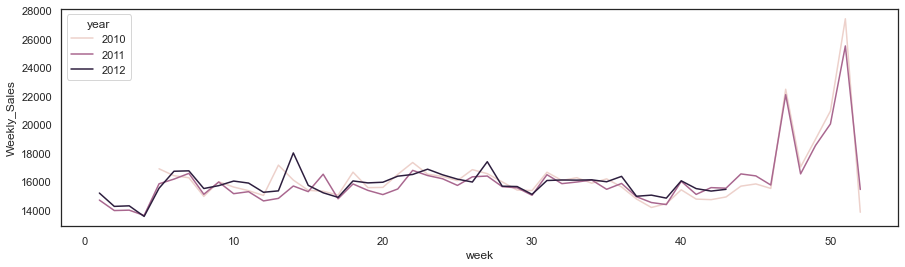

In [403]:
#display the relationship between average weekly sales and year
# we notice that the correlation of weekly sales between years are significant.
#when we design the model, we need to consider the autocorrelation
fig, ax = plt.subplots(figsize=(15, 4))
group = train_df['Weekly_Sales'].groupby([train_df['year'],train_df['week']]).mean().reset_index()
sns.lineplot(data=group, x='week', y="Weekly_Sales", hue = 'year')

In [404]:
pd.DataFrame({'train_df' :train_df.dtypes, 'test_df' :test_df.dtypes})

,train_df,test_df
CPI,float64,float64
Date,datetime64[ns],datetime64[ns]
Dept,int64,int64
IsHoliday_True,uint8,uint8
MarkDown1,float64,float64
MarkDown2,float64,float64
MarkDown3,float64,float64
MarkDown5,float64,float64
Size,int64,int64
Store,int64,int64


In [405]:
#generate dummy variables
train_df = pd.get_dummies(train_df, columns = ['Dept'], drop_first=True)
test_df = pd.get_dummies(test_df, columns = ['Dept'],drop_first=True)
train_df = pd.get_dummies(train_df, columns = ['week'], drop_first=True)
test_df = pd.get_dummies(test_df, columns = ['week'],drop_first=True)
train_df = pd.get_dummies(train_df, columns = ['Store'], drop_first=True)
test_df = pd.get_dummies(test_df, columns = ['Store'],drop_first=True)

#### Part 3 Choose Forecasting Model, Model Evaluation

In [406]:
group = train_df['Weekly_Sales'].groupby([train_df['year']]).count().reset_index()
group

,year,Weekly_Sales
0,2010,140289
1,2011,152970
2,2012,127026


In [410]:
group = test_df['Date'].groupby([test_df['year']]).count().reset_index()
group

,year,Date
0,2012,26789
1,2013,88275


as we can see above, the train data in 2010 and 2011 are about 70% in the total data set. to capture the feature of time series better, we decide to devide the train_df into two parts: trainData, validData:

In [411]:
trainData = train_df[train_df['year'] < 2012]
validData = train_df[train_df['year'] == 2012]

In [453]:
trainData_X = trainData.drop(columns=['Weekly_Sales', 'Date'], axis = 1)
trainData_y = trainData['Weekly_Sales']
validData_X = validData.drop(columns=['Weekly_Sales', 'Date'], axis = 1)
validData_y = validData['Weekly_Sales']

In [425]:
total_lm = LinearRegression()
total_lm.fit(trainData_X, trainData_y)    
regressionSummary(trainData_y, total_lm.predict(trainData_X))


Regression statistics

               Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 13611.8714
     Mean Absolute Error (MAE) : 8243.2654


In [444]:
total_lm = sm.OLS(trainData_y, trainData_X).fit()
regressionSummary(trainData_y, total_lm.predict(trainData_X))
regressionSummary(validData_y, total_lm.predict(validData_X))
sm.OLS(trainData_y, trainData_X).fit().summary()


Regression statistics

               Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 13611.8714
     Mean Absolute Error (MAE) : 8243.2654

Regression statistics

               Mean Error (ME) : 111.5545
Root Mean Squared Error (RMSE) : 12208.9782
     Mean Absolute Error (MAE) : 7997.9110


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     2995.
Date:                Wed, 21 Apr 2021   Prob (F-statistic):               0.00
Time:                        19:55:46   Log-Likelihood:            -3.2076e+06
No. Observations:              293259   AIC:                         6.415e+06
Df Residuals:                  293077   BIC:                         6.417e+06
Df Model:                         181                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Size               4.6085      1.730      2.664      0.008       1.218       8.000
MarkDown1          0.0433      0.020      2.207      0.027       0.005       0.082
MarkDown2          0.0179      0.006      2.784      0.005       0.005       0.031
MarkDown3          0.0398      0.005      8.106      0.000       0.030       0.049
MarkDown5          0.0154      0.014      1.100      0.271      -0.012       0.043
CPI               40.4960     34.325      1.180      0.238     -26.780     107.771
year            -338.4555    133.489     -2.535      0.011    -600.091     -76.820
IsHoliday_True  3432.0618    253.747     13.526      0.000    2934.726    3929.398
Dept_2          2.386e+04    287.053     83.117      0.000    2.33e+04    2.44e+04
Dept_3         -8018.5546    287.053    -27.934      0.000   -8581.170   -7455.940
Dept_4          6211.2321    287.053     21.638      0.000    5648.617    6773.847
Dept_5          3388.3158    288.511     11.744      0.000    2822.842    3953.790
Dept_6         -1.499e+04    292.053    -51.331      0.000   -1.56e+04   -1.44e+04
Dept_7          6541.1408    287.053     22.787      0.000    5978.526    7103.756
Dept_8          1.049e+04    287.053     36.549      0.000    9928.907    1.11e+04
Dept_9           135.0287    288.276      0.468      0.639    -429.985     700.042
Dept_10        -1352.3409    287.053     -4.711      0.000   -1914.956    -789.726
Dept_11        -4932.3941    287.068    -17.182      0.000   -5495.040   -4369.748
Dept_12        -1.552e+04    287.471    -53.993      0.000   -1.61e+04    -1.5e+04
Dept_13         1.103e+04    287.053     38.412      0.000    1.05e+04    1.16e+04
Dept_14        -4229.0604    287.053    -14.733      0.000   -4791.675   -3666.445
Dept_16        -5767.4317    287.053    -20.092      0.000   -6330.047   -5204.817
Dept_17        -9157.7377    287.084    -31.899      0.000   -9720.415   -8595.060
Dept_18        -1.088e+04    310.220    -35.076      0.000   -1.15e+04   -1.03e+04
Dept_19        -2.073e+04    328.088    -63.191      0.000   -2.14e+04   -2.01e+04
Dept_20        -1.478e+04    292.754    -50.473      0.000   -1.53e+04   -1.42e+04
Dept_21        -1.443e+04    287.053    -50.278      0.000    -1.5e+04   -1.39e+04
Dept_22        -1.039e+04    300.409    -34.601      0.000    -1.1e+04   -9805.629
Dept_23         3737.4420    296.600     12.601      0.000    3156.115    4318.769
Dept_24        -1.506e+04    301.080    -50.017      0.000   -1.56e+04   -1.45e+04
Dept_25        -1.062e+04    287.616    -36.908      0.000   -1.12e+04   -1.01e+04
Dept_26         -1.29e+04    296.138    -43.563      0.000   -1.35e+04   -1.23e+04
Dept_27        -1.966e+04    298.526    -65.862      0.000   -2.02e+04   -1.91e+04
Dept_28        -1.955e+04    290.550    -67.283      0.000   -2.01e+04    -1.9e+04
Dept_29     

In [438]:
#take Forward Selection
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(trainData_X[variables], trainData_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(trainData_y, [trainData_y.mean()] * len(trainData_y), model, df=1)
    return AIC_score(trainData_y, model.predict(trainData_X[variables]), model)
best_model, best_variables = forward_selection(trainData_X.columns, train_model, score_model, verbose=True)
print(best_variables)

Variables: Size, MarkDown1, MarkDown2, MarkDown3, MarkDown5, CPI, year, IsHoliday_True, Dept_2, Dept_3, Dept_4, Dept_5, Dept_6, Dept_7, Dept_8, Dept_9, Dept_10, Dept_11, Dept_12, Dept_13, Dept_14, Dept_16, Dept_17, Dept_18, Dept_19, Dept_20, Dept_21, Dept_22, Dept_23, Dept_24, Dept_25, Dept_26, Dept_27, Dept_28, Dept_29, Dept_30, Dept_31, Dept_32, Dept_33, Dept_34, Dept_35, Dept_36, Dept_37, Dept_38, Dept_39, Dept_40, Dept_41, Dept_42, Dept_43, Dept_44, Dept_45, Dept_46, Dept_47, Dept_48, Dept_49, Dept_50, Dept_51, Dept_52, Dept_54, Dept_55, Dept_56, Dept_58, Dept_59, Dept_60, Dept_65, Dept_67, Dept_71, Dept_72, Dept_74, Dept_77, Dept_78, Dept_79, Dept_80, Dept_81, Dept_82, Dept_83, Dept_85, Dept_87, Dept_90, Dept_91, Dept_92, Dept_93, Dept_94, Dept_95, Dept_96, Dept_97, Dept_98, Dept_99, week_2, week_3, week_4, week_5, week_6, week_7, week_8, week_9, week_10, week_11, week_12, week_13, week_14, week_15, week_16, week_17, week_18, week_19, week_20, week_21, week_22, week_23, week_24, w

In [440]:
regressionSummary(validData_y, best_model.predict(validData_X[best_variables]))


Regression statistics

               Mean Error (ME) : 81.3666
Root Mean Squared Error (RMSE) : 12216.7825
     Mean Absolute Error (MAE) : 8009.3095


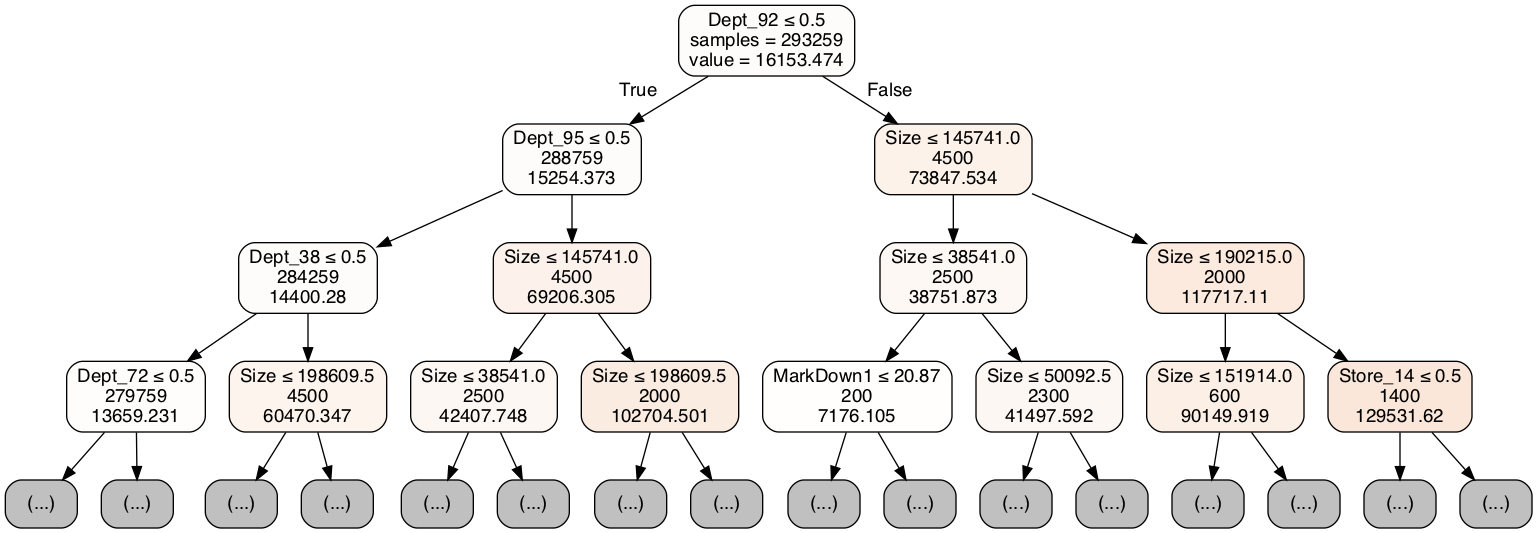

In [459]:
# use the fullClassTree
fullClassTree = DecisionTreeRegressor(random_state=1, max_depth = None)
fullClassTree.fit(trainData_X, trainData_y)
plotDecisionTree(fullClassTree, feature_names=trainData_X.columns, max_depth=4)

In [464]:
param_grid = {
    'max_depth': [5, 15, 25, 30, 45], 
    'min_impurity_decrease': [0, 0.001, 0.005, 0.01, 0.05, 0.1], 
    'min_samples_split': [10, 30, 50, 70, 90, 100]
}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(trainData_X, trainData_y)
print('Initial parameters: ', gridSearch.best_params_)

Initial parameters:  {'max_depth': 45, 'min_impurity_decrease': 0.001, 'min_samples_split': 50}


In [466]:
param_grid = {
    'max_depth': [35, 40, 45, 50, 55], 
    'min_impurity_decrease': [0.0001, 0.0005, 0.001, 0.0015, 0.002], 
    'min_samples_split': [35, 40, 45, 50, 55, 60]
}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(trainData_X, trainData_y)
print('Improved parameters: ', gridSearch.best_params_)

Improved parameters:  {'max_depth': 55, 'min_impurity_decrease': 0.0015, 'min_samples_split': 45}


In [468]:
regTree = gridSearch.best_estimator_
regressionSummary(trainData_y, regTree.predict(trainData_X))
regressionSummary(validData_y, regTree.predict(validData_X))


Regression statistics

               Mean Error (ME) : 0.0000
Root Mean Squared Error (RMSE) : 4774.3719
     Mean Absolute Error (MAE) : 2179.6953

Regression statistics

               Mean Error (ME) : -463.2439
Root Mean Squared Error (RMSE) : 6748.9033
     Mean Absolute Error (MAE) : 3491.7504
